# Introduction
This is a quick and dirty entry for the Kaggle [Titanic competition](https://www.kaggle.com/c/titanic).  The challenge is to identify which people survived using machine learning.  Evaluation is scored with accuracy of predicted survival where `1` is survived and `0` is deceased.

I have another Notebook that delved deeper into the dataset and performed some feature engineering.  This Notebook does not do that as I am already familiar with the data.

# Importing Data
Let's begin by importing the data.

In [1]:
import pandas as pd
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# Cleaning Data
Let's begin by dropping unnecessary columns.

In [2]:
# `PassengerId` has no real impact upon survival rate.
train.drop('PassengerId', axis=1, inplace=True)
# `Ticket` numbers did not the survival rate in a meaningful way.
train.drop('Ticket', axis=1, inplace=True)

# Repeating for the test data, but keeping `PassengerID` as we need that!
test.drop('Ticket', axis=1, inplace=True)

`Age` has some missing values that can be imputed with the median.  `Embarked` has some missing values, but only in the test data, which can be filled with the mode.  `Fare` has missing values, but only in the test data, which can be filled with the median.

In [3]:
# Handle `Age` in both datasets.
train.Age.fillna(train.Age.median(), inplace=True)
test.Age.fillna(test.Age.median(), inplace=True)

# Handle `Embarked` in the training data.
train.Embarked.fillna(train.Embarked.mode()[0], inplace=True)

# Handle `Fare` in the test data.
test.Fare.fillna(test.Fare.median(), inplace=True)

`Sex` is currently using text, so map it to integers.

In [4]:
train['Sex'] = train.Sex.map({'male': 1, 'female': 0})
test['Sex'] = test.Sex.map({'male': 1, 'female': 0})

`Fare` is rather skewed, so log it for nonzero entries.

In [5]:
import numpy as np
train['Fare'] = np.log10(train.Fare.replace(0, np.nan)).replace(np.nan, 0)
test['Fare'] = np.log10(test.Fare.replace(0, np.nan)).replace(np.nan, 0)

`Age` surprisingly has little to no impact on the survival rate with my previous testing.

In [6]:
train.drop(['Age', 'SibSp', 'Parch'], axis=1, inplace=True)
test.drop(['Age', 'SibSp', 'Parch'], axis=1, inplace=True)

The `Cabin` has a lot of missing values, so replace them with an `X`.

In [7]:
train['Cabin'] = pd.Series([x[0] if not pd.isnull(x) else 'X' for x in train.Cabin])
test['Cabin'] = pd.Series([x[0] if not pd.isnull(x) else 'X' for x in test.Cabin])

The train data has a single cabin entry `T`, so just group him in `X` for simplicity.

In [8]:
train['Cabin'].replace('T', 'X', inplace=True)

Looking at `Cabin`, survival rate is almost identical for different cabins, so group similar ones together.

In [9]:
# group cabins
train['Cabin'] = train.Cabin.map({
    'B': 'One', 'D': 'One', 'E': 'One',
    'C': 'Two', 'F': 'Two',
    'A': 'Three', 'G': 'Three',
    'X': 'Four'
})

test['Cabin'] = test.Cabin.map({
    'B': 'One', 'D': 'One', 'E': 'One',
    'C': 'Two', 'F': 'Two',
    'A': 'Three', 'G': 'Three',
    'X': 'Four'
})

The same process for `Embarked`.

In [10]:
# group embarked
train['Embarked'] = train.Embarked.map({
    'S': 'One', 'Q': 'One',
    'C': 'Two'
})

test['Embarked'] = test.Embarked.map({
    'S': 'One', 'Q': 'One',
    'C': 'Two'
})

Feature engineering `Name` didn't increase accuracy for me much in the past (and it clashes with `Sex` among some other variables), so just remeove it.

In [11]:
train.drop('Name', axis=1, inplace=True)
test.drop('Name', axis=1, inplace=True)

Convert categorical values into one-hot encoded values.  I'm not dropping the first element here as I want to check correlation of all of the generated columns.

In [12]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

# Feature Selection
Let's now limit which columns we want to choose.  We can observe this by plotting the correlations, or alternatively, as I have below, we can also color a dataframe.

In [13]:
import seaborn as sns
train.corr().style.background_gradient(sns.diverging_palette(220, 10, as_cmap=True), axis=1)

,Survived,Pclass,Sex,Fare,Cabin_Four,Cabin_One,Cabin_Three,Cabin_Two,Embarked_One,Embarked_Two
Survived,1,-0.338481,-0.543351,0.331805,-0.319572,0.28549,0.0272706,0.130096,-0.16824,0.16824
Pclass,-0.338481,1,0.1319,-0.670489,0.722607,-0.537107,-0.156795,-0.375642,0.243292,-0.243292
Sex,-0.543351,0.1319,1,-0.264751,0.142608,-0.145489,0.0275789,-0.0571196,0.0828535,-0.0828535
Fare,0.331805,-0.670489,-0.264751,1,-0.56036,0.399484,0.0554034,0.347093,-0.261367,0.261367
Cabin_Four,-0.319572,0.722607,0.142608,-0.56036,1,-0.69805,-0.271747,-0.545846,0.210178,-0.210178
Cabin_One,0.28549,-0.537107,-0.145489,0.399484,-0.69805,1,-0.0559705,-0.112425,-0.163428,0.163428
Cabin_Three,0.0272706,-0.156795,0.0275789,0.0554034,-0.271747,-0.0559705,1,-0.0437666,-0.0678779,0.0678779
Cabin_Two,0.130096,-0.375642,-0.0571196,0.347093,-0.545846,-0.112425,-0.0437666,1,-0.0886904,0.0886904
Embarked_One,-0.16824,0.243292,0.0828535,-0.261367,0.210178,-0.163428,-0.0678779,-0.0886904,1,-1
Embarked_Two,0.16824,-0.243292,-0.0828535,0.261367,-0.210178,0.163428,0.0678779,0.0886904,-1,1


Before we trim our dataset, let's store and drop the `PassengerId` from the test dataset.

In [14]:
test_passenger_ids = test.PassengerId
test.drop('PassengerId', axis=1, inplace=True)

In this case, I am choosing `Pclass`, `Sex`, and `Fare`, as they have the highest correlation with the `Survived` column.  I was going to include `Cabin_Four` and/or `Cabin_One` too, but their correlation with `Pclass` is rather high, which could make the model perform worse!

In [15]:
# Keeping:
# Pclass (-0.33, 0.69)
# Sex (-0.54, 0.22)
# Fare (0.33, 0.18)
train = train[['Survived', 'Pclass', 'Sex', 'Fare']]
test = test[['Pclass', 'Sex', 'Fare']]

Create the features (or `X`) and labels (or `y`) for training.

In [16]:
features = train.drop('Survived', axis=1)
labels = train.Survived

A final step is scaling the data since it's not all on the same scale.

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features[features.columns] = scaler.fit_transform(features)
test[test.columns] = scaler.transform(test)

# Training and Submitting
Now we can train!  Below is a helper function from sklearn's documentation for plotting learning curves.

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Using a stratified cross-validation and a randomized search, hunt for the best Random Forest classifier and plot its learning curve.

Random Forest: 0.8282828282828283 / {'n_estimators': 1000, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 2, 'max_depth': 10}


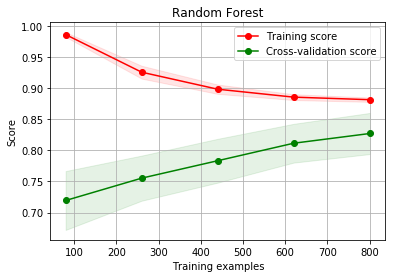

In [25]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier

kfold = StratifiedKFold(n_splits=10)

rf_params = {
    'n_estimators': [1000],
    'max_features': [1, 2, 3],
    'max_depth': [8, 10, 12, 14],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}
cv_rf = RandomizedSearchCV(
    RandomForestClassifier(bootstrap=False),
    rf_params,
    n_iter=100, cv=kfold, scoring='accuracy', random_state=42, n_jobs=-1, iid=True, refit=True)
cv_rf.fit(features, labels)
print('Random Forest: {} / {}'.format(cv_rf.best_score_, cv_rf.best_params_))

plot_learning_curve(cv_rf.best_estimator_, 'Random Forest', features, labels, cv=kfold)
plt.show()

Using the best estimator found in the search, predict and submit.

In [26]:
predicted_survival = cv_rf.best_estimator_.predict(test)
print(predicted_survival)

submission = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Survived': predicted_survival
})
submission.to_csv('./submissions/final.csv', index=False)

print('Done!')

[0 1 0 0 1 0 0 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0
 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 1 1 0 1 0 1 0 1 0
 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 1 1
 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0
 0 1 1 1 1 1 0 1 0 0 0]
Done!


A bonus - plot the ROC curve for the entire cross-validation using the best estimator.  After the initial prediction, I did this to check the accuracy of the model in more detail and to see if I could alter the threshold using `predict_proba()` instead of just `predict()` to get a higher score.

In this case, tuning the threshold made the results worse, although some of the individual splits did show significant increase with higher thresholds.  The mean result, however, did not.

Regardless, code follows for predicting probabilities of binary classification problems using a threshold.

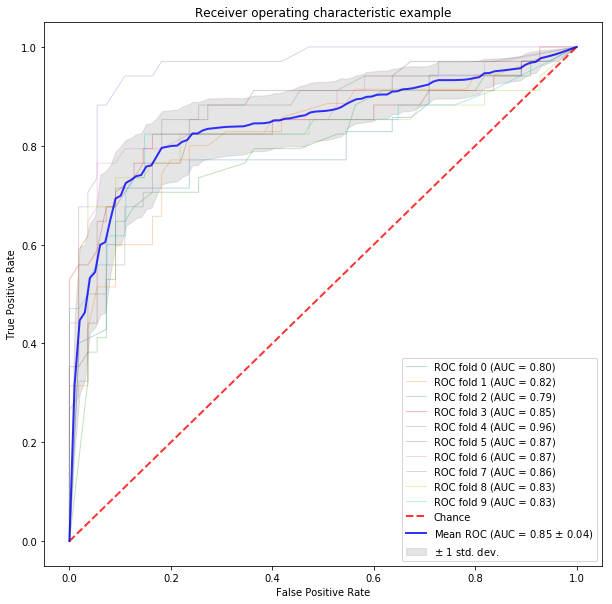

In [42]:
from sklearn.metrics import roc_curve, auc
from scipy import interp

plt.figure(figsize=(10, 10))

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i = 0
for train_idx, test_idx in kfold.split(features, labels):
    probas = cv_rf.best_estimator_.fit(features.iloc[train_idx], labels.iloc[train_idx]).predict_proba(features.iloc[test_idx])
    fpr, tpr, thresholds = roc_curve(labels.iloc[test_idx], probas[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1
#end

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)
#
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
#
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
    

#predicted_probs = cv_rf.best_estimator_.predict_proba(test)
#predicted_probs = predicted_probs[:, 1]
#predicted_probs

#from sklearn.metrics import precision_recall_curve, auc
#precision, recall, thresholds = precision_recall_curve(labels)

In [1]:
#predict_probabs = cv_rf.best_estimator_.predict_proba(test)
#predict_probabs = predict_probabs[:, 1]

#predicted_survival = (predict_probabs >= 0.65).astype(int)
#print(predicted_survival)

#submission = pd.DataFrame({
#    'PassengerId': test_passenger_ids,
#    'Survived': predicted_survival
#})
#submission.to_csv('./submissions/final_proba.csv', index=False)

#print('Done!')